### LIBRARIES

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tifffile as tiff # tiff processing
import matplotlib.pyplot as plt # visualization

### UTILITIES

In [2]:
def plot_samples(
    data: pd.DataFrame, 
    sample_ids: list,
    annotate: bool = False,
    cols: int = 2,
    figsize: tuple = (18, 5)
):
    """
    Plot a grid of specified samples.
    
    Parameters
    ----------
    data
        A dataframe with the metadata on the samples.
    sample_ids
        A list of the sample IDs to plot.
    annotate
        Optionally, whether to annotate the samples or not.
    cols
        Optionally, the number of columns for the grid.
    figsize
        Optionally, a tuple containg the figure size in the form (width, height).
    """
    # Infer rows.
    items = len(sample_ids)
    rows, x = items // cols, items % cols # x carries the reminder if it exists.
    rows = rows if x == 0 else rows + 1
    
    # Set up figure.
    if not (isinstance(figsize, tuple) and len(figsize)==2):
        raise ValueError("Please provide a valid figsize i.e. (width, height)")
    fig = plt.figure(figsize=(figsize[0], figsize[1] * rows))
    
    # Plotting loop.
    for idx, sample_id in enumerate(sample_ids):
        ax = fig.add_subplot(rows, cols, idx + 1)
        # Sample metadata.
        sample_metadata = data[data['id']==sample_id].squeeze()
        ax.imshow(tiff.imread(sample_metadata.file_path))
        
        # Add annotations if necessary.
        if annotate:
            ax.imshow(
                rle2mask(sample_metadata.rle, (sample_metadata.img_width, sample_metadata.img_height)),
                cmap='coolwarm', alpha=0.5)
            
        ax.axis("off")
        ax.set_title(f"{sample_metadata.organ}, {sample_metadata.sex}")
    plt.tight_layout()
    
    
def mask2rle(
    mask:np.array
):
    """
    Encode mask using run length encoding.
    
    Parameters
    ----------
    mask
         A numpy array, 1 - mask, 0 - background
    
    Returns
    -------
    A run length encoding of the mask as a string formated.
    
    Notes
    -----
    Reference: https://www.kaggle.com/paulorzp/rle-functions-run-length-encode-decode
    """
    pixels= mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)



def rle2mask(
    mask_rle: str, 
    shape: tuple= (3000,3000)
):
    """
    Convert a run length encoding to a mask.
    
    Parameters
    ----------
    mask_rle
        A run-length as string formated (start length).
    shape
        The shape of the image to which the rle is to be unencoded (width,height).
        
    Returns
    -------
        A numpy array, 1 - mask, 0 - background.
        
    Notes
    -----
    Reference: https://www.kaggle.com/paulorzp/rle-functions-run-length-encode-decode
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

### DATA

In [3]:
data_path = '../input/hubmap-organ-segmentation' # Path to the data.
train = pd.read_csv(f"{data_path}/train.csv")
test = pd.read_csv(f"{data_path}/test.csv")
submission = pd.read_csv(f"{data_path}/sample_submission.csv")

#### Feature Description
- `id` - The image ID.
- `organ` - The organ that the biopsy sample was taken from.
- `data_source` - Whether the image was provided by HuBMAP or HPA.
- `img_height` - The height of the image in pixels.
- `img_width` - The width of the image in pixels.
- `pixel_size` - The height/width of a single pixel from this image in micrometers. All HPA images have a pixel size of 0.4 µm. For HuBMAP imagery the pixel size is 0.5 µm for kidney, 0.2290 µm for large intestine, 0.7562 µm for lung, 0.4945 µm for spleen, and 6.263 µm for prostate.
- `tissue_thickness` - The thickness of the biopsy sample in micrometers. All HPA images have a thickness of 4 µm. The HuBMAP samples have tissue slice thicknesses 10 µm for kidney, 8 µm for large intestine, 4 µm for spleen, 5 µm for lung, and 5 µm for prostate.
- `rle` - The target column. A run length encoded copy of the annotations. Provided for the training set only.
- `age` - The patient's age in years. Provided for the training set only.
- `sex` - The sex of the patient. Provided for the training set only.

In [4]:
display(train.head())
display(train.shape)

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


(351, 10)

In [5]:
sum(train['id'].value_counts()>1) # One to one target labelling.

0

In [6]:
#  What is the distribution of the organs from which the biopsy were taken?
train.organ.value_counts()

kidney            99
prostate          93
largeintestine    58
spleen            53
lung              48
Name: organ, dtype: int64

In [7]:
# What is the distribution of data sources?
train.data_source.value_counts()

HPA    351
Name: data_source, dtype: int64

How will the algorithm generalize to HUBMAP sourced images?

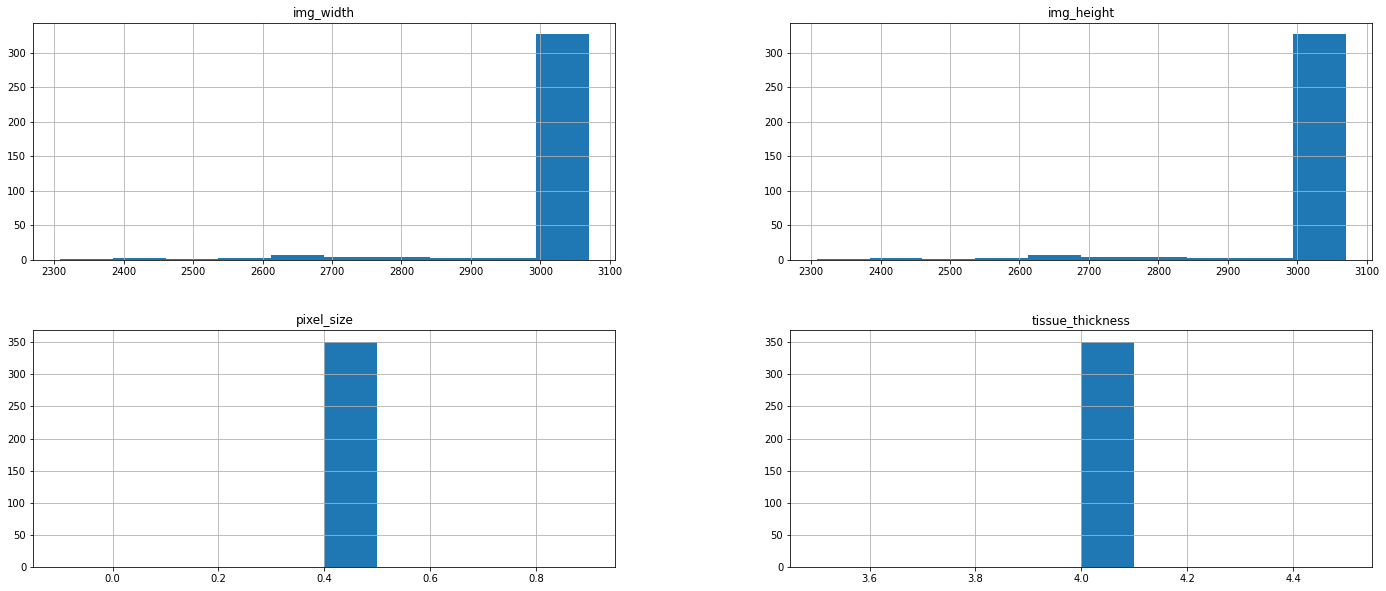

In [8]:
# Image dimensions.
train[['img_width', 'img_height', 'pixel_size', 'tissue_thickness']].hist(figsize=(24,10))
plt.show()

- Majority of images are 3000x3000.
- No variance in the pixel_size, tissue_thickness, but it does exist in the HUBMAP dataset.

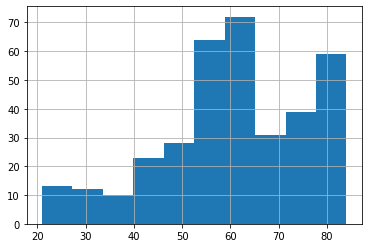

In [9]:
train['age'].hist()
plt.show() # 20 <----> 85.

Do the organ looks vary across ages? We shall have to confirm.

In [10]:
train['sex'].value_counts()

Male      229
Female    122
Name: sex, dtype: int64

Could there be variance across sex?

#### TEST

In [11]:
test.head() # Nothing to do here.

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness
0,10078,spleen,Hubmap,2023,2023,0.4945,4


#### SUBMISSION FILE

In [12]:
submission.head() # Un-huh!

,id,rle
0,10078,12 34


#### IMAGE DATASET

In [13]:
# Add file paths.
train['file_path'] = data_path + '/train_images/' + train['id'].astype(str) + '.tiff'

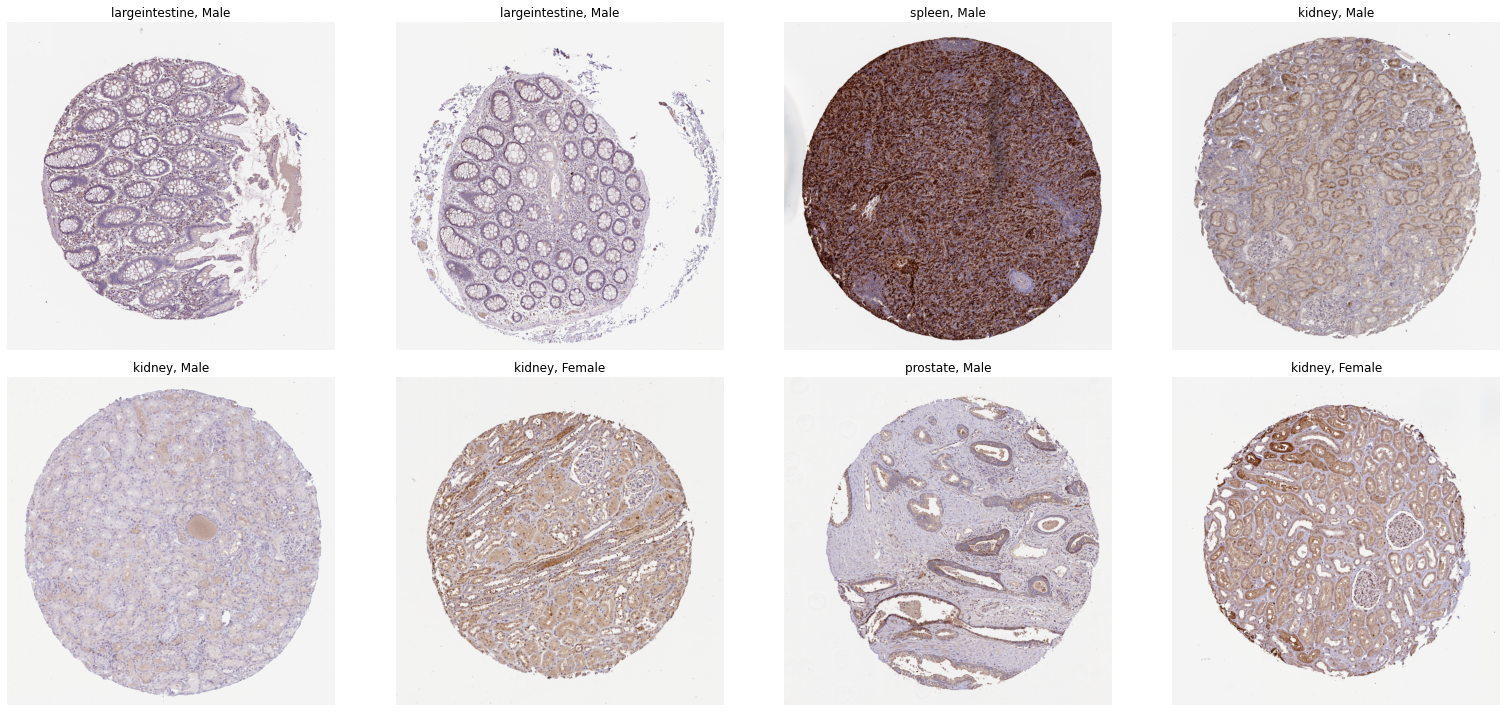

In [14]:
# Plot random samples without annotations.
plot_samples(data=train, sample_ids=train.sample(8)['id'].values, cols=4, figsize=(22, 5))

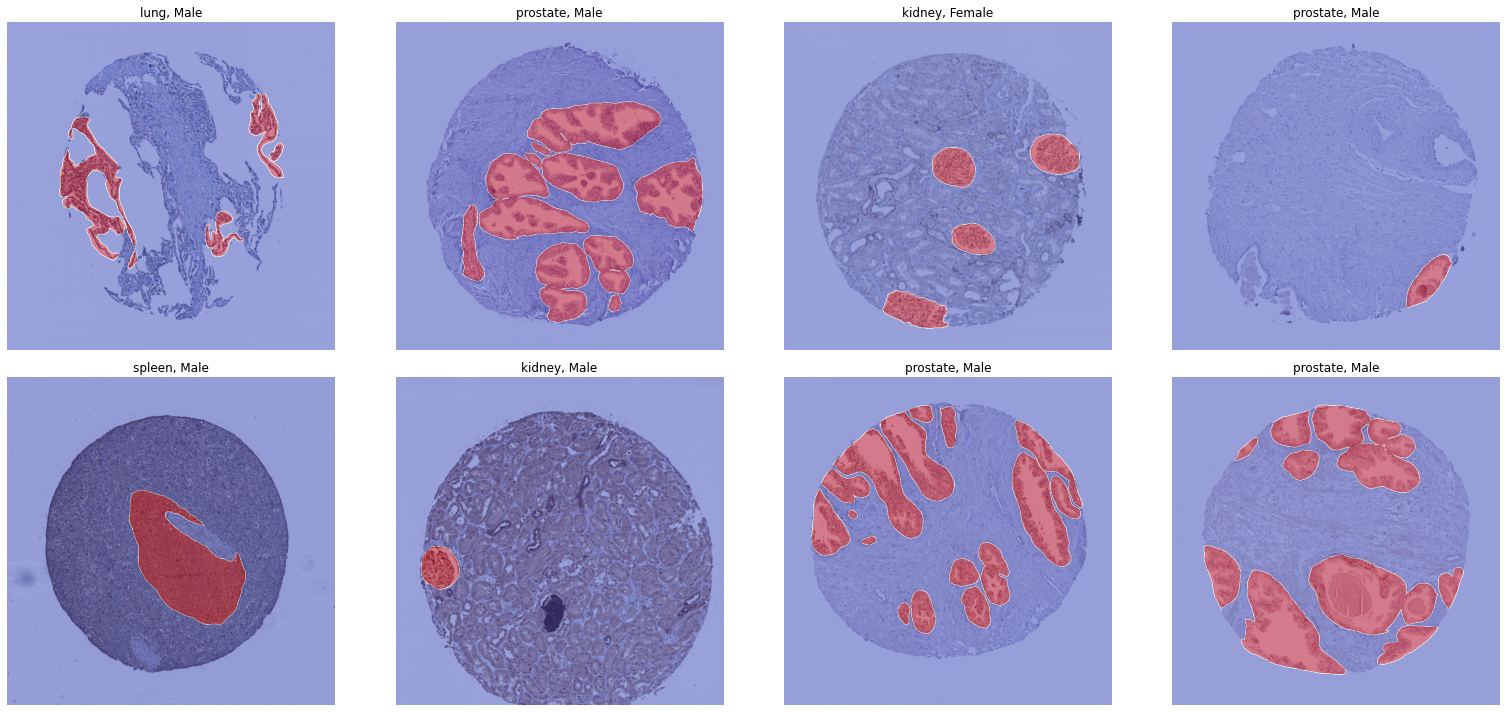

In [15]:
# Add annotations of the functional tissue units.
plot_samples(data=train, sample_ids=train.sample(8)['id'].values, annotate=True, cols=4, figsize=(22, 5))